# XGBoost API

In [10]:
import xgboost as xgb

clf = xgb.XGBClassifier()

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

categories = ['alt.atheism', 'talk.religion.misc']
newsgroups_train = fetch_20newsgroups(subset='train',categories = categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

vect = TfidfVectorizer(min_df=5)

X_train = vect.fit_transform(newsgroups_train.data)
y_train = newsgroups_train.target
X_test = vect.transform(newsgroups_test.data)
y_test = newsgroups_test.target

feature_names = np.asarray(vect.get_feature_names())

## Core Data Structure

In [38]:
dtrain = xgb.DMatrix(X_train,
                     label = y_train,
                    feature_names=feature_names)
dtest = xgb.DMatrix(X_test, 
                    label = y_test,
                    feature_names=feature_names,
                    missing=None)

"""
Data Matrix used in XGBoost.

DMatrix is a internal data structure that used by XGBoost
which is optimized for both memory efficiency and training speed.
You can construct DMatrix from numpy.arrays
Init docstring:
Parameters
----------
data : string/numpy.array/scipy.sparse/pd.DataFrame/dt.Frame
    Data source of DMatrix.
    When data is string type, it represents the path libsvm format txt file,
    or binary file that xgboost can read from.
label : list or numpy 1-D array, optional
    Label of the training data.
missing : float, optional
    Value in the data which needs to be present as a missing value. If
    None, defaults to np.nan.
weight : list or numpy 1-D array , optional
    Weight for each instance.

    .. note:: For ranking task, weights are per-group.

        In ranking task, one weight is assigned to each group (not each data
        point). This is because we only care about the relative ordering of
        data points within each group, so it doesn't make sense to assign
        weights to individual data points.

silent : boolean, optional
    Whether print messages during construction
feature_names : list, optional
    Set names for features.
feature_types : list, optional
    Set types for features.
nthread : integer, optional
    Number of threads to use for loading data from numpy array. If -1,
    uses maximum threads available on the system."""

print()

In [39]:
#To get names of data columns
feat_names = dtrain.feature_names

#to get y values
dtrain.get_label()

#To get number of features
print("num_col: ", dtrain.num_col())
print("num_row: ", dtrain.num_row())

num_col:  4369
num_row:  857


## Booster

A Booster of XGBoost.

Booster is the model of xgboost, that contains low level routines for
training, prediction and evaluation.

----------
params : dict
    Parameters for boosters.
cache : list
    List of cache items.
model_file : string
    Path to the model file.

In [18]:
bst = xgb.Booster(model_file='model0001.model')

#get feature importances
bst.get_fscore()

"""
get_score(fmap='', importance_type='weight')
Get feature importance of each feature. Importance type can be defined as:

‘weight’: the number of times a feature is used to split the data across all trees.
‘gain’: the average gain across all splits the feature is used in.
‘cover’: the average coverage across all splits the feature is used in.
‘total_gain’: the total gain across all splits the feature is used in.
‘total_cover’: the total coverage across all splits the feature is used in.
"""

bst.get_score(importance_type='gain')

#predict must be a DMatrix
ypred = bst.predict(dtest)

#same model
#bst.save_model(filename)

# Learning API

In [45]:
"""
xgb.train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
Docstring:
Train a booster with given parameters.

Parameters
----------
params : dict
    Booster params.
dtrain : DMatrix
    Data to be trained.
num_boost_round: int
    Number of boosting iterations.
evals: list of pairs (DMatrix, string)
    List of items to be evaluated during training, this allows user to watch
    performance on the validation set.
obj : function
    Customized objective function.
feval : function
    Customized evaluation function.
maximize : bool
    Whether to maximize feval.
early_stopping_rounds: int
    Activates early stopping. Validation error needs to decrease at least
    every **early_stopping_rounds** round(s) to continue training.
    Requires at least one item in **evals**.
    If there's more than one, will use the last.
    Returns the model from the last iteration (not the best one).
    If early stopping occurs, the model will have three additional fields:
    ``bst.best_score``, ``bst.best_iteration`` and ``bst.best_ntree_limit``.
    (Use ``bst.best_ntree_limit`` to get the correct value if
    ``num_parallel_tree`` and/or ``num_class`` appears in the parameters)
evals_result: dict
    This dictionary stores the evaluation results of all the items in watchlist.

    Example: with a watchlist containing
    ``[(dtest,'eval'), (dtrain,'train')]`` and
    a parameter containing ``('eval_metric': 'logloss')``,
    the **evals_result** returns

    .. code-block:: python

        {'train': {'logloss': ['0.48253', '0.35953']},
         'eval': {'logloss': ['0.480385', '0.357756']}}

verbose_eval : bool or int
    Requires at least one item in **evals**.
    If **verbose_eval** is True then the evaluation metric on the validation set is
    printed at each boosting stage.
    If **verbose_eval** is an integer then the evaluation metric on the validation set
    is printed at every given **verbose_eval** boosting stage. The last boosting stage
    / the boosting stage found by using **early_stopping_rounds** is also printed.
    Example: with ``verbose_eval=4`` and at least one item in **evals**, an evaluation metric
    is printed every 4 boosting stages, instead of every boosting stage.
learning_rates: list or function (deprecated - use callback API instead)
    List of learning rate for each boosting round
    or a customized function that calculates eta in terms of
    current number of round and the total number of boosting round (e.g. yields
    learning rate decay)
xgb_model : file name of stored xgb model or 'Booster' instance
    Xgb model to be loaded before training (allows training continuation).
callbacks : list of callback functions
    List of callback functions that are applied at end of each iteration.
    It is possible to use predefined callbacks by using
    :ref:`Callback API <callback_api>`.
    Example:

    .. code-block:: python

        [xgb.callback.reset_learning_rate(custom_rates)]

Returns
-------
Booster : a trained booster model"""
parameters = {'max_depth':2,
         'eta':1,
         'silent':True,
          'learning_rate':0.1,   
         'objective':'binary:logistic' }
res={}

bst = xgb.train(parameters,
                dtrain,
                num_boost_round=100,
                evals=[(dtrain,"train"),(dtest,"test")],
               early_stopping_rounds=10,
               evals_result=res)

[0]	train-error:0.316219	test-error:0.385965
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 10 rounds.
[1]	train-error:0.316219	test-error:0.385965
[2]	train-error:0.316219	test-error:0.385965
[3]	train-error:0.271879	test-error:0.352632
[4]	train-error:0.225204	test-error:0.32807
[5]	train-error:0.225204	test-error:0.32807
[6]	train-error:0.225204	test-error:0.32807
[7]	train-error:0.22287	test-error:0.32807
[8]	train-error:0.22287	test-error:0.32807
[9]	train-error:0.1972	test-error:0.321053
[10]	train-error:0.1972	test-error:0.321053
[11]	train-error:0.203034	test-error:0.32807
[12]	train-error:0.2007	test-error:0.329825
[13]	train-error:0.180863	test-error:0.319298
[14]	train-error:0.177363	test-error:0.321053
[15]	train-error:0.169195	test-error:0.314035
[16]	train-error:0.17853	test-error:0.312281
[17]	train-error:0.168028	test-error:0.312281
[18]	train-error:0.152859	test-error:0.305263
[19]	t

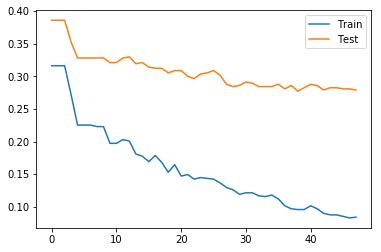

In [33]:
import matplotlib.pyplot as plt
plt.plot(res['train']['error'],label="Train")
plt.plot(res['test']['error'],label="Test")
plt.legend()
plt.show()

## Scikit-Learn Wrapper

In [42]:
clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100,
                        verbosity=1, silent=None, objective='binary:logistic',    
                        booster='gbtree', n_jobs=1)
clf.fit(X_train,y_train)
ypred = clf.predict(X_test)
#clf.save_model()
yprobs = clf.predict_proba(X_test)

#get underlying booster
#bst = clf.get_booster()

C:\Users\Harrison\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


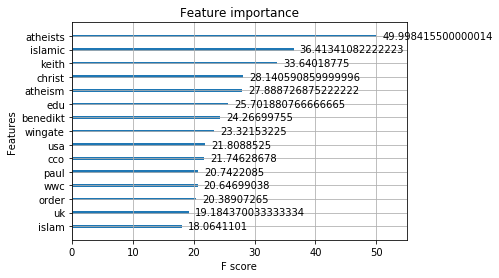

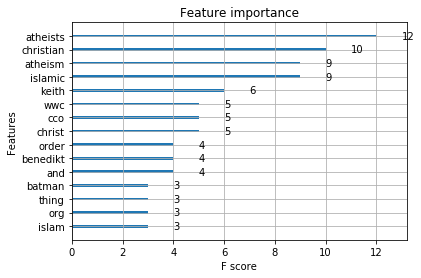

In [48]:
xgb.plot_importance(bst,
                    importance_type='gain',
                   max_num_features=15)

plt.show()
xgb.plot_importance(bst,
                    importance_type='weight',
                   max_num_features=15)

plt.show()